In [564]:
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [565]:
df=pd.read_csv("dataset_57_hypothyroid.csv", parse_dates=True, encoding='UTF-8',
               true_values=['t'], false_values=['f'], na_values=['?'])


In [566]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41.0,F,False,False,False,False,False,False,False,False,...,True,125.0,True,1.14,True,109.0,False,NaN,SVHC,negative
1,23.0,F,False,False,False,False,False,False,False,False,...,True,102.0,False,NaN,False,NaN,False,NaN,other,negative
2,46.0,M,False,False,False,False,False,False,False,False,...,True,109.0,True,0.91,True,120.0,False,NaN,other,negative
3,70.0,F,True,False,False,False,False,False,False,False,...,True,175.0,False,NaN,False,NaN,False,NaN,other,negative
4,70.0,F,False,False,False,False,False,False,False,False,...,True,61.0,True,0.87,True,70.0,False,NaN,SVI,negative


In [567]:
df.replace("F", 0, inplace=True)
df.replace("M", 1, inplace=True)
# df.replace("negative", 1, inplace=True)
df.replace("M", 1, inplace=True)
df['age'].replace(0.0, np.nan, inplace=True)

In [568]:
pandas_profiling.ProfileReport(df)


Number of variables,30
Number of observations,3772
Total Missing (%),5.4%
Total size in memory,368.4 KiB
Average record size in memory,100.0 B
Numeric,7
Categorical,2
Boolean,18
Date,0
Text (Unique),0
Rejected,3


Заполним пропуски в данных:

In [569]:
total = df.isnull().sum().sort_values(ascending=False)
total

TBG                          3772
T3                            769
T4U                           387
FTI                           385
TSH                           369
TT4                           231
sex                           150
age                             1
query_hypothyroid               0
I131_treatment                  0
thyroid_surgery                 0
pregnant                        0
on_antithyroid_medication       0
sick                            0
lithium                         0
query_on_thyroxine              0
on_thyroxine                    0
query_hyperthyroid              0
Class                           0
goitre                          0
tumor                           0
referral_source                 0
psych                           0
TSH_measured                    0
T3_measured                     0
TT4_measured                    0
T4U_measured                    0
FTI_measured                    0
TBG_measured                    0
hypopituitary 

В колонке TBG данных совсем нет, удаляем.

In [570]:
df.drop(columns=['TBG'], inplace=True)

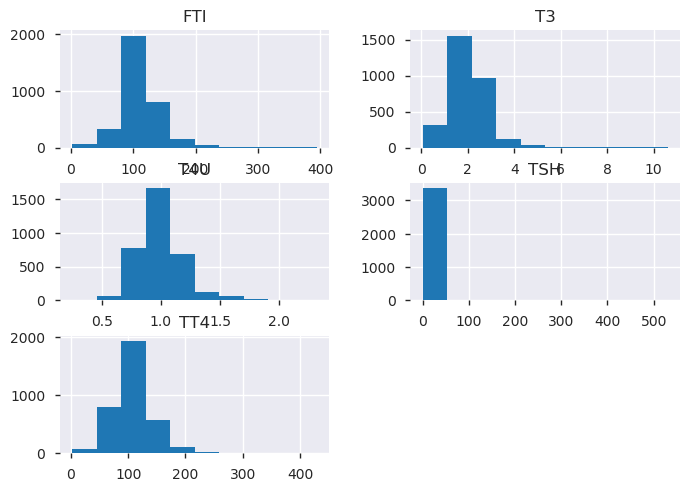

In [571]:
_ = df[['T3', 'T4U', 'FTI', 'TSH', 'TT4']].hist()

заполняем средними значениями

In [572]:
df.fillna(df.mean(), inplace=True)

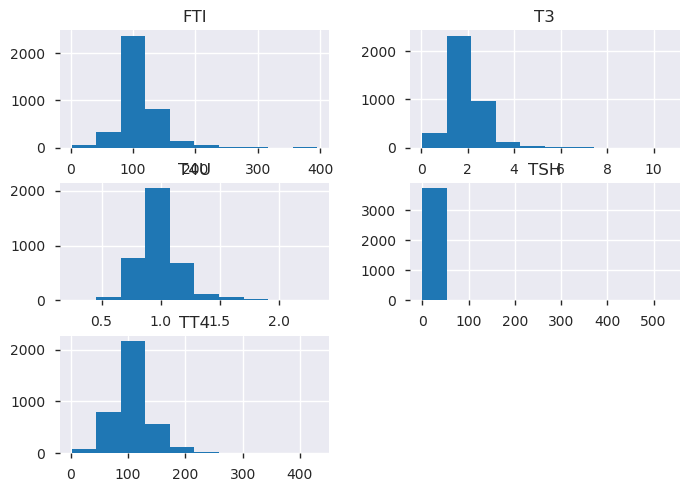

In [573]:
_ = df[['T3', 'T4U', 'FTI', 'TSH', 'TT4']].hist()

In [574]:
df['Class'].value_counts()

negative                   3481
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

из данных:

- FTI_measured сильно кореллирует с T4U_measured (ρ = 0.99712), уберём одну из анализа
- TBG, TBG_measured - константы

FTI, T3, T4U, TSH, TT4, age - количественные переменные


referral_source - многоклассовая, понадобится ОНЕ.

In [575]:
df.drop(columns=['TSH_measured', 'T3_measured', 'TT4_measured',
                'T4U_measured', 'FTI_measured', 'TBG_measured'],
        inplace=True)

In [576]:
numeric_columns = ['FTI', 'T3', 'T4U', 'TSH', 'TT4', 'age']


In [577]:
df = pd.concat([df,pd.get_dummies(df['referral_source'], prefix='referral_source')],axis=1)
df.drop(columns=['referral_source'], inplace=True)

In [578]:
df.replace('True', 1, inplace=True)
df.replace('False', 0, inplace=True)

Добавим преобразование Бокса-Кокса для количесвенных параметров, FunctionTransformer будет идти в пайплайне первым:

In [579]:
from scipy.stats import boxcox

def boxcox_column(input_df):
    result_df = pd.DataFrame(data=input_df)
    result_df['age'] = boxcox(result_df['age'])[0]
    return result_df


## Построение моделей

In [580]:
cv_scores = {}

In [581]:
import operator
# method for printing output coefs from multiclass classification
def get_coefs(model):  
    classes = model.classes_
    coefs = model.coef_
    
    for target, coefs in zip(classes, coefs):   
        print(target)
        coefs_dict = dict(zip(X.columns, coefs))
        sorted_dict = sorted(coefs_dict.items(), key=operator.itemgetter(1), reverse=True)
        print(sorted_dict[:5])

In [582]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import FunctionTransformer


### Делим выборку на обучающую и тест части:

In [583]:
from sklearn.model_selection import train_test_split
y = df["Class"]
X = df.drop(columns=["Class"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df["Class"])

Сначала попробуем ovr подход. Из метрик посчитаем следующие:
- среднюю точность на кроссвалидации. Классы несбалансированы, так что оценка будет не совсем показательна, но для сравнения моделей подойдет.
- матрицу ошибок на отложенной выборке(точность, полнота, f1, support) - более точные оценки по каждому из классов.

In [584]:
pipe = make_pipeline(FunctionTransformer(boxcox_column, validate=False), StandardScaler(), LogisticRegression(multi_class='ovr'))
y = df["Class"]
X = df.drop(columns=["Class"])
scores = cross_val_score(pipe, X, y, cv=4)
print("cv score = " + str(np.mean(scores)))
cv_scores['logreg_ovr'] = np.mean(scores)

cv score = 0.94645045527385


In [585]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(metrics.classification_report(y_pred, y_test))

                         precision    recall  f1-score   support

compensated_hypothyroid       0.16      0.53      0.24        17
               negative       1.00      0.95      0.97      1096
    primary_hypothyroid       0.64      0.95      0.77        19
  secondary_hypothyroid       0.00      0.00      0.00         0

            avg / total       0.98      0.95      0.96      1132



compensated_hypothyroid и secondary_hypothyroid имеют довольно низкую точность т.к. у них мало сэмплов.

In [586]:
get_coefs(pipe.named_steps['logisticregression'])

compensated_hypothyroid
[('T4U', 0.4114454342160968), ('psych', 0.24016508817058552), ('query_hypothyroid', 0.2281652921907418), ('referral_source_other', 0.160077578451598), ('referral_source_SVHD', 0.08949275693000841)]
negative
[('on_thyroxine', 3.297497745053435), ('thyroid_surgery', 2.4434832733878538), ('TT4', 0.9153783655638565), ('goitre', 0.3116448961063519), ('referral_source_SVHC', 0.27940703660500954)]
primary_hypothyroid
[('TSH', 0.9220695091583967), ('referral_source_SVI', 0.2537837028399422), ('tumor', 0.18319354865785156), ('referral_source_STMW', 0.14050500162043963), ('query_hypothyroid', 0.09286325163125193)]
secondary_hypothyroid
[('FTI', 0.5890039479041557), ('T4U', 0.3868632716025143), ('query_hypothyroid', 0.30204277456693174), ('sex', 0.1692913515295319), ('T3', 0.10851254796200242)]


из интересного:
- thyroid_surgery - проведенная операция сильно увеличивает шанс отсутствия болезни;
- on_thyroxine - аналогично;
- основные признаки primary_hypothyroid - TSH, T4U, referral_source_STMW
- основные признаки secondary_hypothyroid - FTI, T4U, query_hypothyroid
- основные признаки compensated_hypothyroid - T4U, query_hypothyroid, psych
T4U фигурирует везде в признаках болезней.

Попробуем balanced веса из-за несбалансированных классов + multinomial алгоритм

In [587]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df["Class"])
pipe = make_pipeline(StandardScaler(), LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced'))
y = df["Class"]
X = df.drop(columns=["Class"])
scores = cross_val_score(pipe, X, y, cv=4)
print("cv score = " + str(np.mean(scores)))
cv_scores['logreg_multinomial_balanced'] = np.mean(scores)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(metrics.classification_report(y_pred, y_test))

cv score = 0.9602334673168994
                         precision    recall  f1-score   support

compensated_hypothyroid       0.90      0.66      0.76        79
               negative       0.97      1.00      0.98      1018
    primary_hypothyroid       0.89      0.74      0.81        34
  secondary_hypothyroid       0.00      0.00      0.00         1

            avg / total       0.96      0.96      0.96      1132



compensated_hypothyroid стал отлавливаться лучше, немного увеличилась кф оценка.

In [588]:
get_coefs(pipe.named_steps['logisticregression'])

compensated_hypothyroid
[('TSH', 4.1852478228683765), ('TT4', 1.2190687189772094), ('query_hyperthyroid', 0.3131536447382532), ('FTI', 0.2545631849479957), ('sick', 0.2006430631804952)]
negative
[('TT4', 2.024622376537082), ('on_thyroxine', 1.7485091129373351), ('thyroid_surgery', 0.9853928773531263), ('I131_treatment', 0.4203848177059792), ('query_hyperthyroid', 0.279691979001179)]
primary_hypothyroid
[('TSH', 5.172907776221598), ('T4U', 0.6735632123485785), ('referral_source_STMW', 0.39627206843086116), ('referral_source_SVI', 0.24568224293493254), ('referral_source_SVHC', 0.08177641533900842)]
secondary_hypothyroid
[('query_hypothyroid', 1.0923622896934615), ('FTI', 0.9825704842867903), ('sex', 0.9470578741220169), ('T3', 0.9402826047626407), ('age', 0.6547368110081315)]


- thyroid_surgery и on_thyroxine все так же значимы для негативного класса, добавился ТТ4;
- основные признаки primary_hypothyroid - те же;
- основные признаки secondary_hypothyroid - FTI остался, Т3 и  ыуч стали более значимы.
- основные признаки compensated_hypothyroid - TSH, TT4, psych


Подберем параметр регуляризации:

In [589]:
npa = np.asarray(X_train['age'])
any(npa <= 0)

False

In [590]:
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
pipe = make_pipeline(StandardScaler(), LogisticRegression(multi_class='ovr', solver='lbfgs', class_weight='balanced'))
                                                          
grid = GridSearchCV(estimator=pipe, param_grid=dict(logisticregression__C=Cs), cv=4, n_jobs=1, verbose=True)
_ = grid.fit(X_train, y_train) 

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    1.5s finished


In [591]:
print(str(max(grid.cv_results_['mean_test_score'])))
cv_scores['logreg_balanced_C'] = np.mean(max(grid.cv_results_['mean_test_score']))

0.953030303030303


In [592]:
y_pred = grid.best_estimator_.predict(X_test)
print(metrics.classification_report(y_pred, y_test))

                         precision    recall  f1-score   support

compensated_hypothyroid       0.81      0.62      0.70        76
               negative       0.97      0.99      0.98      1019
    primary_hypothyroid       0.86      0.69      0.76        35
  secondary_hypothyroid       0.00      0.00      0.00         2

            avg / total       0.95      0.96      0.95      1132



Значения метрик немного улучшились.

In [593]:
get_coefs(grid.best_estimator_.named_steps['logisticregression'])

compensated_hypothyroid
[('TSH', 3.065112501546193), ('T4U', 0.4512909647669347), ('query_hypothyroid', 0.21665794523664975), ('psych', 0.09303868018104747), ('query_on_thyroxine', 0.07799030776298842)]
negative
[('goitre', 3.601719874092722), ('on_thyroxine', 3.0707366195159564), ('pregnant', 2.4134920613273296), ('lithium', 2.104534940811), ('TT4', 1.94991846456547)]
primary_hypothyroid
[('TSH', 4.712773741147406), ('referral_source_SVI', 1.0429217456802478), ('referral_source_STMW', 0.7820272991520896), ('referral_source_other', 0.22631712317167066), ('query_hypothyroid', 0.13541889767989823)]
secondary_hypothyroid
[('FTI', 2.8584379434686067), ('T4U', 2.584697451417326), ('T3', 2.3711591003626453), ('sex', 2.2828463313006715), ('query_hypothyroid', 2.082854434528707)]


Попробуем оversampling. Undersampling использовать будет довольно тяжело из-за сильного дисбаланса некоторых классов, будет потеряно слишеом много записей.

In [594]:
from imblearn import over_sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df["Class"])
oversampler = over_sampling.RandomOverSampler()
X_sm, y_sm = oversampler.fit_sample(X, y)

In [595]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(multi_class='ovr', solver='lbfgs'))
scores = cross_val_score(pipe, X_sm, y_sm, cv=4)
print("cv score = " + str(np.mean(scores)))
cv_scores['logreg_oversample'] = np.mean(scores)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(metrics.classification_report(y_pred, y_test, ))

cv score = 0.9129565204481571
                         precision    recall  f1-score   support

compensated_hypothyroid       0.14      0.89      0.24         9
               negative       1.00      0.95      0.97      1095
    primary_hypothyroid       0.82      0.82      0.82        28
  secondary_hypothyroid       0.00      0.00      0.00         0

            avg / total       0.99      0.95      0.96      1132



Точность довольно сильно ухудшилась относительно предыдущих моделей. Впрочем, сравнивать кроссвалидацию немного некорректно из-за различных выборок, на отложенной результат близок к лог регрессии с ovr стратегией.

## KNN 

Так как есть классы с небольшим количеством образцов, выберем n=3

In [596]:
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df["Class"])
pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))

X = df.drop(columns=["Class"])
scores = cross_val_score(pipe, X, y, cv=4)
print("cv score = " + str(np.mean(scores)))
cv_scores['knn'] = np.mean(scores)


pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(metrics.classification_report(y_pred, y_test))

cv score = 0.9374377678015926
                         precision    recall  f1-score   support

compensated_hypothyroid       0.12      0.50      0.19        14
               negative       1.00      0.94      0.97      1103
    primary_hypothyroid       0.54      1.00      0.70        15
  secondary_hypothyroid       0.00      0.00      0.00         0

            avg / total       0.98      0.94      0.96      1132



С оверсэмплингом:

In [597]:
y_sm.shape

(13924,)

In [598]:
X_sm_train, _, y_sm_train, _ = train_test_split(X_sm, y_sm, test_size=0.3)
scores = cross_val_score(pipe, X_sm, y_sm, cv=4)
print("cv score = " + str(np.mean(scores)))
cv_scores['knn_oversample'] = np.mean(scores)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(metrics.classification_report(y_pred, y_test))

cv score = 0.9757265562109876
                         precision    recall  f1-score   support

compensated_hypothyroid       0.12      0.50      0.19        14
               negative       1.00      0.94      0.97      1103
    primary_hypothyroid       0.54      1.00      0.70        15
  secondary_hypothyroid       0.00      0.00      0.00         0

            avg / total       0.98      0.94      0.96      1132



In [599]:
cv_scores

{'logreg_ovr': 0.94645045527385,
 'logreg_multinomial_balanced': 0.9602334673168994,
 'logreg_balanced_C': 0.953030303030303,
 'logreg_oversample': 0.9129565204481571,
 'knn': 0.9374377678015926,
 'knn_oversample': 0.9757265562109876}

Из моделей все показали себя примерно одинаково. Лучшей оказалась логистическая регрессия с подобранным через gridsearch C и сбалансированными весами классов. Оверсэмплинг с knn показал так же неплохие результаты на кроссвалидации(что не совсем корректно сравнивать ввиду изменившейся выборки) так и на отложенной выборке. 